In [1]:
import cv2
import numpy as np
from IPython.display import display, clear_output
from ultralytics import YOLO
import ipywidgets as widgets
import matplotlib.pyplot as plt


In [2]:

# Load YOLOv8 model
model = YOLO('yolov8m.pt')  # fast + lightweight

# Get COCO class names
COCO_CLASSES = model.names


In [4]:

# Class selector widget
class_selector = widgets.SelectMultiple(
    options=list(COCO_CLASSES.values()),
    value=['person', 'cat', 'dog'],
    description='Select classes to detect:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)
display(class_selector)


SelectMultiple(description='Select classes to detect:', index=(0, 15, 16), layout=Layout(width='50%'), options…

In [5]:

# Video source selector
video_path_widget = widgets.Text(
    value='dog_cat_child.mp4',  # Default to webcam
    description='Video Source:',
    layout=widgets.Layout(width='75%')
)
display(video_path_widget)


Text(value='dog_cat_child.mp4', description='Video Source:', layout=Layout(width='75%'))

In [6]:

# Stop button and flag
stop_button = widgets.Button(description="🛑 Stop Detection", button_style='danger')
stop_flag = widgets.ToggleButton(value=False, description='Stop Flag', layout=widgets.Layout(display='none'))

def stop_detection(b):
    stop_flag.value = True

stop_button.on_click(stop_detection)
display(stop_button)


Button(button_style='danger', description='🛑 Stop Detection', style=ButtonStyle())

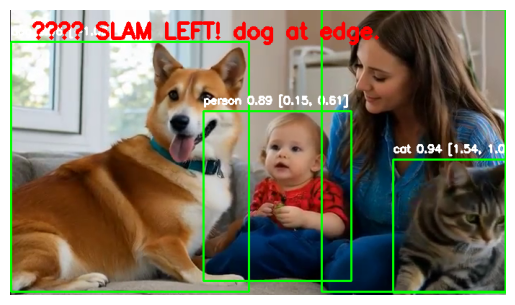

✅ Stream ended.
✅ Detection complete.


In [7]:

# Compute relative position
def get_relative_position(box_center, frame_center):
    x_rel = 2 * (box_center[0] - frame_center[0]) / frame_center[0]
    y_rel = 2 * (box_center[1] - frame_center[1]) / frame_center[1]
    return round(x_rel, 2), round(y_rel, 2)

# Load video or webcam
video_source = video_path_widget.value
cap = cv2.VideoCapture(int(video_source)) if video_source.isdigit() else cv2.VideoCapture(video_source)

if not cap.isOpened():
    print("❌ Unable to open video source.")
else:
    ret, frame = cap.read()
    if not ret:
        print("❌ Unable to read from source.")
    else:
        h, w = frame.shape[:2]
        frame_center = np.array([w / 2, h / 2])
        print("🎥 Starting detection...")

        try:
            frame_count = 0
            while True:
                if stop_flag.value:
                    print("🛑 Detection stopped by user.")
                    break

                ret, frame = cap.read()
                if not ret:
                    print("✅ Stream ended.")
                    break

                results = model(frame)[0]
                annotated_frame = frame.copy()
                output_data = []

                for i, det in enumerate(results.boxes):
                    cls_id = int(det.cls[0])
                    cls_name = COCO_CLASSES[cls_id]

                    if cls_name not in class_selector.value:
                        continue

                    conf = float(det.conf[0])
                    x1, y1, x2, y2 = map(int, det.xyxy[0])
                    box_center = np.array([(x1 + x2) / 2, (y1 + y2) / 2])
                    rel_x, rel_y = get_relative_position(box_center, frame_center)

                    label = f"{cls_name} {conf:.2f} [{rel_x}, {rel_y}]"
                    cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(annotated_frame, label, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

                    output_data.append({
                        "frame": frame_count,
                        "id": i,
                        "class": cls_name,
                        "confidence": round(conf, 2),
                        "rel_position": {"x": rel_x, "y": rel_y}
                    })

                # Print and overlay Slam Nav feedback
                if output_data:
                    obj = output_data[0]  # Only use the first detected object for feedback
                    rel_x = obj['rel_position']['x']
                    rel_y = obj['rel_position']['y']

                    if abs(rel_x) > 1.0:
                        direction = "LEFT" if rel_x < 0 else "RIGHT"
                        slam_msg = f"🚨 SLAM {direction}! {obj['class']} at edge."
                    elif abs(rel_y) > 1.0:
                        slam_msg = f"⚠️ {obj['class']} too high/low"
                    else:
                        slam_msg = f"✅ {obj['class']} centered"

                    print(slam_msg)

                    # Draw message on frame
                    cv2.putText(annotated_frame, slam_msg, (30, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

                for obj in output_data:
                    print(obj)

                # Convert BGR to RGB
                annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

                # Display
                clear_output(wait=True)
                plt.imshow(annotated_frame_rgb)
                plt.axis('off')
                plt.show()

                frame_count += 1

        finally:
            cap.release()
            print("✅ Detection complete.")
